- Notebook modified from https://www.kaggle.com/code/markwijkhuizen/planttraits2024-eda-training-pub.
- Notebook further modified from https://www.kaggle.com/code/hdjojo/modified-planttraits2024-eda-training/notebook.

In [1]:
import numpy as np
import pandas as pd
import imageio.v3 as imageio
import albumentations as A

from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torch import nn
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler

import torch
import timm
import torchmetrics
import time

tqdm.pandas()

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.13 (you have 1.4.12). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [2]:
class Config():
    IMAGE_SIZE = 384
    BACKBONE = 'swin_large_patch4_window12_384.ms_in22k_ft_in1k'
    TARGET_COLUMNS = ['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean']
    N_TARGETS = len(TARGET_COLUMNS)
    BATCH_SIZE = 10
    LR_MAX = 1.e-4
    WEIGHT_DECAY = 0.01
    N_EPOCHS = 6
    TRAIN_MODEL = True
    IS_INTERACTIVE = True
    Lower_Quantile = 0.005
    Upper_Quantile = 0.985
        
CONFIG = Config()

In [3]:
train = pd.read_csv('./data/train.csv')
train['file_path'] = train['id'].apply(lambda s: f'./data/train_images/{s}.jpeg')
train['jpeg_bytes'] = train['file_path'].progress_apply(lambda fp: open(fp, 'rb').read())

for column in CONFIG.TARGET_COLUMNS:
    lower_quantile = train[column].quantile(CONFIG.Lower_Quantile)
    upper_quantile = train[column].quantile(CONFIG.Upper_Quantile)
    train = train[(train[column] >= lower_quantile) & (train[column] <= upper_quantile)]

CONFIG.N_TRAIN_SAMPLES = len(train)
CONFIG.N_STEPS_PER_EPOCH = (CONFIG.N_TRAIN_SAMPLES // CONFIG.BATCH_SIZE)
CONFIG.N_STEPS = CONFIG.N_STEPS_PER_EPOCH * CONFIG.N_EPOCHS + 1

test = pd.read_csv('./data/test.csv')
test['file_path'] = test['id'].apply(lambda s: f'./data/test_images/{s}.jpeg')
test['jpeg_bytes'] = test['file_path'].progress_apply(lambda fp: open(fp, 'rb').read())
test.to_pickle('test.pkl')

print('N_TRAIN_SAMPLES:', len(train), 'N_TEST_SAMPLES:', len(test))

  0%|          | 0/43363 [00:00<?, ?it/s]

  0%|          | 0/6391 [00:00<?, ?it/s]

N_TRAIN_SAMPLES: 38420 N_TEST_SAMPLES: 6391


In [4]:
LOG_FEATURES = ['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean']

y_train = np.zeros_like(train[CONFIG.TARGET_COLUMNS], dtype=np.float32)
for target_idx, target in enumerate(CONFIG.TARGET_COLUMNS):
    v = train[target].values
    if target in LOG_FEATURES:
        v = np.log10(v)
    y_train[:, target_idx] = v

SCALER = StandardScaler()
y_train = SCALER.fit_transform(y_train)

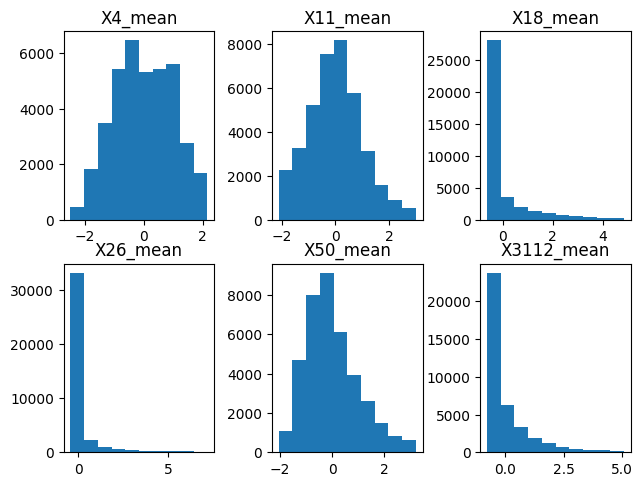

In [9]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,3)
fig.tight_layout()
for i in range(6):
    axs[int(i/3), i%3].hist(y_train[:,i])
    axs[int(i/3), i%3].set_title(LOG_FEATURES[i])


In [11]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

TRAIN_TRANSFORMS = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomSizedCrop(
            [112, 128],
            CONFIG.IMAGE_SIZE, CONFIG.IMAGE_SIZE, w2h_ratio=1.0, p=0.8),
        A.Resize(CONFIG.IMAGE_SIZE, CONFIG.IMAGE_SIZE),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
        A.ImageCompression(quality_lower=85, quality_upper=100, p=0.3),
        A.ToFloat(),
        A.Normalize(mean=MEAN, std=STD, max_pixel_value=1),
        ToTensorV2(),
    ])

TEST_TRANSFORMS = A.Compose([
        A.Resize(CONFIG.IMAGE_SIZE, CONFIG.IMAGE_SIZE),
        A.ToFloat(),
        A.Normalize(mean=MEAN, std=STD, max_pixel_value=1),
        ToTensorV2(),
    ])

class Dataset(Dataset):
    def __init__(self, X_jpeg_bytes, y, transforms=None):
        self.X_jpeg_bytes = X_jpeg_bytes
        self.y = y
        self.transforms = transforms

    def __len__(self):
        return len(self.X_jpeg_bytes)

    def __getitem__(self, index):
        X_sample = self.transforms(
            image=imageio.imread(self.X_jpeg_bytes[index]),
        )['image']
        y_sample = self.y[index]
        
        return X_sample, y_sample

train_dataset = Dataset(
    train['jpeg_bytes'].values,
    y_train,
    TRAIN_TRANSFORMS,
)

train_dataloader = DataLoader(
        train_dataset,
        batch_size=CONFIG.BATCH_SIZE,
        shuffle=True,
        drop_last=True,
)

test_dataset = Dataset(
    test['jpeg_bytes'].values,
    test['id'].values,
    TEST_TRANSFORMS,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    drop_last=False,
)

In [12]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(
                CONFIG.BACKBONE,
                num_classes=CONFIG.N_TARGETS,
                pretrained=True)
        
    def forward(self, inputs):
        return self.backbone(inputs)

model = Model()
model = model.to('cuda')
print(model)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/swin_large_patch4_window12_384.ms_in22k_ft_in1k)
INFO:timm.models._hub:[timm/swin_large_patch4_window12_384.ms_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (head.fc.weight, head.fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


Model(
  (backbone): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (layers): Sequential(
      (0): SwinTransformerStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=192, out_features=576, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=192, out_features=192, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path1): Identity()
            (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=192, out_features=768, bias=

In [13]:
def get_lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=CONFIG.LR_MAX,
        total_steps=CONFIG.N_STEPS,
        pct_start=0.1,
        anneal_strategy='cos',
        div_factor=1e1,
        final_div_factor=1e1,
    )

# def get_lr_scheduler(optimizer):
#     return torch.optim.lr_scheduler.LinearLR(
#         optimizer,
#         start_factor=1e-3,
#         total_iters = 6
#     )

MAE = torchmetrics.regression.MeanAbsoluteError().to('cuda')
R2 = torchmetrics.regression.R2Score(num_outputs=CONFIG.N_TARGETS, multioutput='uniform_average').to('cuda')

Y_MEAN = torch.tensor(y_train).mean(dim=0).to('cuda')

LOSS_FN = nn.SmoothL1Loss() # r2_loss

optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=CONFIG.LR_MAX,
    weight_decay=CONFIG.WEIGHT_DECAY,
)

LR_SCHEDULER = get_lr_scheduler(optimizer)

In [14]:
print("Start Training:")
for epoch in range(CONFIG.N_EPOCHS):
    MAE.reset()
    R2.reset()
    model.train()
        
    for step, (X_batch, y_true) in enumerate(train_dataloader):
        X_batch = X_batch.to('cuda')
        y_true = y_true.to('cuda')
        t_start = time.perf_counter_ns()
        y_pred = model(X_batch)
        loss = LOSS_FN(y_pred, y_true)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        LR_SCHEDULER.step()
        MAE.update(y_pred, y_true)
        R2.update(y_pred, y_true)

        if CONFIG.IS_INTERACTIVE:
            print(
                f'\rEPOCH {epoch+1:02d}, {step+1:04d}/{CONFIG.N_STEPS_PER_EPOCH} | ' + 
                f'mae: {MAE.compute().item():.4f}, r2: {R2.compute().item():.4f}, ' +
                f'step: {(time.perf_counter_ns()-t_start)*1e-9:.3f}s, lr: {LR_SCHEDULER.get_last_lr()[0]:.2e}',
                end='\n' if (step + 1) == CONFIG.N_STEPS_PER_EPOCH else '', flush=True,
            )

torch.save(model, 'model.pth')

Start Training:
EPOCH 01, 0007/3842 | mae: 0.7879, r2: -0.1434, step: 20.099s, lr: 1.00e-04

: 

In [ ]:
model = torch.load('./model.pth')

C:\Users\zhang\AppData\Local\Temp\ipykernel_17664\3441913578.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('./model.pth')


In [ ]:
SUBMISSION_ROWS = []
model.eval()

for X_sample_test, test_id in tqdm(test_dataloader):
    with torch.no_grad():
        y_pred = model(X_sample_test.to('cuda')).detach().cpu().numpy()
    
    y_pred = SCALER.inverse_transform(y_pred).squeeze()
    row = {'id': test_id}
    
    for k, v in zip(CONFIG.TARGET_COLUMNS, y_pred):
        if k in LOG_FEATURES:
            row[k.replace('_mean', '')] = 10 ** v
        else:
            row[k.replace('_mean', '')] = v

    SUBMISSION_ROWS.append(row)
    
submission_df = pd.DataFrame(SUBMISSION_ROWS)
submission_df.to_csv('submission.csv', index=False)
print("Submit!")

  0%|          | 0/6391 [00:00<?, ?it/s]

Submit!
